In [6]:
import sys
import os
import logging
import math
import random
import numpy as np
import tensorflow as tf
import scipy
import skimage.color
import skimage.io
import skimage.transform
import urllib.request
import shutil
import warnings
from distutils.version import LooseVersion

C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kwon\anaconda3\envs\GPUtest\lib\site-packages\tensorflow\pyth

In [36]:
def resize_img(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """ Resizes an image keeping the aspect ratio unchanged. The code changed from Mask R-CNN by Matteport
        https://github.com/matterport/Mask_RCNN
    
    image: image_id
    min_dim: if provided, resizes the image such that it's smaller (dimension == min_dim)
    max_dim: if provided, ensures that the image longest side does not exceed this value
    min_scale: if provided, ensure that the image is scaled up by at least this percent
               even if min_dim does not require it
    mode: Resizing mode
            none: No resizing
            square: padding with zeros to get a square image
            pad64: pads width and height with zeros to make them multiples of 64.
                   max_dim will be ignored.
                   The multiple of 64 is needed to ensure smooth scaling of feature maps
                   up and doewn the 6 levels of the FPN pyramid (2**6=64)
            crop: picks random crops from the image. Can be used in training only.
    
    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might be inserted in the returned image.
            If this window is the coordinates of the image part of the full image (excluding the padding).
            The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)] - support up to 3 dimnesion
    """
    
    # Keep track of image dtype and return results inthe same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0 ,0)]
    crop = None
    
    if mode == "none":
        return image, window, scale, padding, crop
    
    # Scale - Calculate scale based on min_dim & min_scale
    if min_dim:
        # Scale up but not down - Why?
        scale = max(1, min_dim / min(h, w))
        print("Minimum dimension and scale: ", min_dim, scale)
    if min_scale and scale < min_scale:
        scale = min_scale
        print("Minimum scale and scale: ", min_scale, scale)
    
    # Does it exceed max_dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max*scale) > max_dim:
            scale = max_dim / image_max
    
    # Resize image using bilinear interpolation
    if scale != 1:
        image = resize(image, (round(h * scale), round(w * scale)), preserve_range=True)
        
    # Now, padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        widow = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        widow = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop  

In [31]:
def resize(image, output_shape, order=1, mode='constant', cval=0, clip=True, 
           preserve_range=False, anti_aliasing=False, anti_aliasing_sigma=None):
    """A wrapper for Scikit-Image resize()
    
    Scikit-Image generates warnings on every call to resize() if it doesn't
    receive the right parameters. The right parameters depend on the version 
    of skimage. This solved the problem by using different parameters per
    version. And it provides a centrla place ot control resizing defaults.
    """
    if LooseVersion(skimage.__version__) >= LooseVersion("0.14"):
        # New in 0.14: anti_aliasing. Dafulat it to False for backward
        # compatibility with skimage 0.13
        return skimage.transform.resize(image, output_shape,
                                       order=order, mode=mode, cval=cval, clip=clip,
                                       preserve_range=preserve_range, anti_aliasing=anti_aliasing,
                                       anti_aliasing_sigma=anti_aliasing_sigma)
    else:
        return skimage.transform.resize(image, output_shape,
                                       order=order, mode=mode, cval=cval, clip=clip,
                                       preserve_range=preserve_range)

In [32]:
def resize_mask(mask, scale, padding, crop=None):
    """Resizes a mask using the given scale and padding
    Typically, sclae and padding from resize_image() to 
    ensure both, the image and the mask, are resized consistently.
    
    scale: mask scaling factor
    padding: padding to add to the mask in the form
            [(top, bottom), (left, right), (0, 0)]
    """
    # Suppress warning from scipy 0.13.0, the output shape of zoom() is
    # calculated with round() instead of int()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mask = scipy.ndimage.zoom(mask, zoom=[scale, scale, 1], order=0)
    if crop is not None:
        y, x, h, w = crop
        mask = mask[y:y + h, x:x + w]
    else:
        mask = np.pad(mask, padding, mode='constant', constant_values=0)
    return mask

In [17]:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from bridge import BridgeDataset

In [21]:
dataset_train = BridgeDataset()
dataset_train.load_bridge(os.path.join(ROOT_DIR,"bridge/"),"train")

type:  <class 'dict'>
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 62, 68, 73, 76, 80, 89, 96, 98, 106, 95, 87, 82, 74, 68, 60, 54], 'all_points_y': [64, 332, 328, 330, 330, 331, 333, 332, 330, 328, 61, 56, 52, 50, 50, 54, 59]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [33, 38, 68, 76, 74, 63], 'all_points_y': [50, 258, 259, 256, 48, 49]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 60, 94, 85], 'all_points_y': [38, 255, 255, 36]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 53, 70, 72, 69, 65], 'all_points_y': [50, 160, 160, 158, 51, 50]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 57, 76, 69, 52], 'all_points_y': [53, 167, 167, 50, 50]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
ob

objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 50, 61, 67, 83, 88, 95, 96], 'all_points_y': [1, 177, 178, 178, 179, 177, 174, 1]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [37, 36, 44, 49, 55, 56, 50, 45, 41, 40], 'all_points_y': [45, 116, 120, 121, 120, 44, 42, 42, 42, 43]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [55, 50, 57, 64, 75, 92, 99, 106, 115, 111, 100, 81, 70, 63], 'all_points_y': [48, 146, 151, 156, 158, 159, 157, 154, 48, 46, 45, 44, 45, 46]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [18, 25, 30, 37, 46, 53, 63, 73, 78, 79, 77, 63, 49, 36, 23], 'all_points_y': [43, 145, 148, 148, 149, 149, 147, 143, 140, 139, 43, 43, 40, 40, 41]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': '

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [46, 42, 46, 69, 70, 51], 'all_points_y': [53, 140, 140, 135, 53, 49]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [57, 55, 54, 50, 53, 52, 144, 131, 126, 119, 114, 108, 97, 90, 84, 79, 69, 64, 59], 'all_points_y': [24, 40, 50, 87, 143, 196, 196, 24, 19, 16, 14, 12, 11, 11, 11, 12, 16, 18, 21]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [54, 49, 90, 93, 93, 53], 'all_points_y': [50, 191, 191, 55, 49, 47]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [57, 50, 59, 73, 85, 96, 110, 120, 135, 144, 152, 154, 149, 139, 124, 114, 100, 83, 76, 65, 63], 'all_points_y': [60, 453, 459, 465, 467, 467, 467, 467, 465, 461, 457, 61, 57, 53, 51, 51, 49, 50, 51, 54, 54]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'nam

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 54, 68, 83, 94, 97, 96, 94, 88, 83, 77, 71, 65, 60, 56], 'all_points_y': [29, 238, 243, 242, 240, 240, 26, 23, 21, 20, 20, 20, 21, 22, 23]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 56, 65, 77, 82, 78, 72, 64, 58, 54], 'all_points_y': [53, 183, 186, 186, 183, 53, 49, 50, 51, 53]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 53, 64, 71, 69, 65, 59, 54, 50], 'all_points_y': [53, 126, 127, 126, 51, 50, 50, 51, 52]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 52, 57, 61, 64, 66, 65, 60, 55, 51], 'all_points_y': [51, 107, 107, 107, 107, 107, 51, 50, 50, 51]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 85, 142, 756, 690, 80, 50], 'all_points_y': [242, 16

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 156, 208, 254, 323, 399, 427, 457, 464, 308, 295, 264, 202, 161, 113, 83], 'all_points_y': [108, 1002, 1047, 1080, 1110, 1123, 1118, 1112, 1108, 73, 60, 49, 56, 60, 73, 88]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 146, 219, 267, 321, 349, 224, 204, 172, 124, 89, 59], 'all_points_y': [93, 650, 695, 719, 728, 723, 54, 50, 50, 61, 70, 78]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 135, 160, 204, 275, 290, 189, 145, 100, 63], 'all_points_y': [71, 488, 508, 530, 551, 551, 49, 51, 60, 69]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [32, 26, 32, 38, 45, 48, 53, 56, 62, 56, 44, 38, 33], 'all_points_y': [50, 153, 150, 148, 140, 139, 134, 132, 52, 51, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
p

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 61, 69, 76, 82, 83, 73, 69, 65, 58, 56, 52], 'all_points_y': [15, 166, 168, 169, 170, 170, 11, 9, 9, 10, 10, 12]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 108, 4137, 4141, 4130, 3168, 1842, 528, 171], 'all_points_y': [171, 540, 555, 100, 49, 100, 108, 112, 112]}]
objects: ['rectangular']
numids [2]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 53, 70, 119, 114, 108, 102, 96, 88, 80, 67, 59, 53], 'all_points_y': [47, 237, 237, 235, 42, 39, 37, 36, 34, 34, 36, 38, 41]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 51, 63, 68, 67, 66, 60, 54, 51], 'all_points_y': [7, 159, 159, 159, 9, 7, 6, 7, 7]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 53, 56, 63, 68, 69, 68, 63, 61, 57, 54], 'all_

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [52, 50, 57, 66, 70, 72, 72, 71, 64, 53], 'all_points_y': [50, 152, 153, 154, 153, 152, 52, 50, 49, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 51, 58, 65, 70, 74, 71, 64, 57, 55], 'all_points_y': [52, 153, 155, 156, 156, 155, 52, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [52, 50, 57, 68, 72, 74, 69, 64, 57, 55], 'all_points_y': [53, 147, 150, 149, 148, 52, 50, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [56, 50, 64, 74, 76, 70, 65, 60], 'all_points_y': [52, 149, 151, 148, 51, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [15, 6, 14, 22, 30, 36, 33, 24, 18, 16], 'all_points_y': [51, 147, 147, 146, 144, 53, 50, 50, 50, 51]}]
o

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 73, 302, 344, 344, 252, 178, 87], 'all_points_y': [68, 752, 729, 716, 59, 50, 50, 64]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 96, 101, 381, 647, 789, 748, 674, 564, 394, 270], 'all_points_y': [113, 1564, 1720, 1724, 1715, 1697, 113, 86, 63, 49, 58]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 156, 1452, 1268, 1190, 1055, 935, 779, 631, 482, 291, 227], 'all_points_y': [234, 3752, 3752, 248, 163, 114, 85, 50, 50, 57, 107, 135]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 55, 92, 127, 174, 214, 240, 240, 232, 186, 151, 111, 81], 'all_points_y': [70, 807, 816, 821, 823, 814, 804, 77, 61, 56, 49, 52, 57]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [14, 42, 42, 60, 83, 108, 120, 131, 102], 'all_points_y': [2, 162, 166, 166, 165, 163, 161, 159, 1]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [61, 50, 69, 81, 92, 92, 88, 78, 71, 67], 'all_points_y': [55, 173, 176, 177, 77, 54, 52, 50, 50, 51]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [19, 0, 9, 19, 27, 31, 50, 47, 42, 38, 34, 31, 30], 'all_points_y': [33, 142, 146, 148, 149, 150, 40, 36, 34, 32, 31, 30, 30]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [53, 49, 75, 78, 75, 68, 57], 'all_points_y': [51, 124, 124, 54, 52, 50, 49]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [56, 50, 65, 71, 81, 79], 'all_points_y': [0, 104, 105, 105, 2, 1]}]
objects: ['cylinder']
numids

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [23, 30, 35, 43, 56, 66, 71, 75, 71], 'all_points_y': [50, 174, 175, 175, 173, 173, 171, 168, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 52, 57, 71, 87, 91, 92], 'all_points_y': [51, 155, 157, 157, 155, 153, 49]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 52, 58, 65, 69, 68], 'all_points_y': [50, 106, 107, 107, 105, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [58, 50, 57, 72, 78, 88, 88], 'all_points_y': [49, 141, 142, 143, 142, 54, 52]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [48, 35, 1, 0], 'all_points_y': [52, 214, 214, 45]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [74, 50, 58, 6

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 96, 125, 144, 149, 119, 89, 73, 58], 'all_points_y': [64, 235, 229, 226, 224, 51, 49, 52, 54]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 105, 125, 141, 143, 143, 117, 81, 56], 'all_points_y': [60, 224, 221, 217, 217, 162, 49, 50, 58]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [87, 50, 66, 100, 119, 148, 100, 89], 'all_points_y': [52, 271, 276, 279, 279, 56, 50, 49]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [84, 50, 76, 115, 119, 147], 'all_points_y': [49, 214, 222, 223, 224, 56]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [26, 0, 13, 43, 68, 70, 96, 93, 64, 41, 28], 'all_points_y': [51, 252, 261, 265, 265, 262, 61, 56, 51, 49, 50]}]
objects: ['cylinder']
n

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [33, 18, 31, 45, 55, 69, 63, 58, 57], 'all_points_y': [1, 98, 100, 102, 103, 10, 4, 1, 1]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [62, 50, 66, 74, 76, 86, 82, 75, 71, 68], 'all_points_y': [32, 108, 110, 110, 110, 45, 42, 37, 34, 33]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [61, 50, 61, 67, 71, 72, 78, 76, 71], 'all_points_y': [49, 103, 105, 105, 105, 102, 60, 57, 54]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [65, 49, 63, 73, 75, 89, 81], 'all_points_y': [49, 127, 125, 122, 119, 54, 52]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [58, 49, 58, 65, 70, 78], 'all_points_y': [49, 99, 97, 95, 93, 53]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygo

numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [4, 1, 68, 74], 'all_points_y': [1, 162, 163, 0]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [36, 23, 29, 39, 46, 57, 52, 44, 38, 37], 'all_points_y': [10, 171, 171, 170, 168, 11, 6, 4, 4, 5]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [56, 50, 56, 62, 68, 71, 74, 71, 68, 62, 60], 'all_points_y': [9, 171, 172, 171, 171, 170, 9, 6, 4, 6, 6]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 51, 57, 65, 68, 71, 69, 67, 62, 57, 53], 'all_points_y': [9, 168, 171, 171, 171, 169, 9, 7, 6, 6, 7]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 61, 68, 78, 84, 74, 65, 58, 53], 'all_points_y': [15, 167, 170, 169, 168, 10, 9, 10, 12]}]
objects: ['cylinder']
n

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [42, 39, 46, 51, 56, 61, 55, 50], 'all_points_y': [52, 150, 149, 146, 143, 52, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [54, 50, 55, 61, 68, 69, 71, 68, 61, 59], 'all_points_y': [50, 121, 123, 122, 122, 121, 51, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 50, 56, 61, 67, 69, 70], 'all_points_y': [50, 118, 116, 115, 115, 115, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 52, 114, 108, 97, 93, 59], 'all_points_y': [6, 186, 185, 4, 2, 0, 0]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 50, 95, 93, 87, 76, 67, 61], 'all_points_y': [42, 186, 185, 44, 41, 41, 41, 41]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  

objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [63, 49, 93, 107, 101, 87, 75, 71], 'all_points_y': [12, 166, 166, 19, 14, 10, 9, 10]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [51, 49, 80, 83, 73, 66, 62, 57], 'all_points_y': [52, 142, 142, 54, 52, 50, 49, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [34, 7, 67, 84, 81, 76, 66, 56, 50, 46], 'all_points_y': [16, 193, 193, 26, 20, 15, 12, 10, 10, 11]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 50, 78, 76, 72, 63, 59, 55], 'all_points_y': [53, 149, 149, 52, 50, 50, 50, 50]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 54, 57, 62, 70, 72, 68, 63, 57], 'all_points_y': [51, 116, 119, 120, 121, 121, 50, 49, 50]}]
obj

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [419, 50, 230, 461, 1852, 1938, 2324, 2212, 1878, 1723, 1294, 951, 710, 564], 'all_points_y': [238, 4040, 4160, 4203, 4238, 4160, 393, 273, 144, 109, 49, 67, 84, 152]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 1707, 3260, 3269, 2427, 2213, 2076, 1758, 1629, 814, 428, 239, 136], 'all_points_y': [779, 4616, 4616, 2007, 67, 50, 50, 50, 67, 213, 402, 522, 608]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [9, 455, 712, 1073, 1425, 1940, 2575, 2789, 2832, 2189, 17], 'all_points_y': [1536, 4489, 4566, 4643, 4634, 4583, 4446, 4257, 4205, 26, 17]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [281, 50, 127, 230, 341, 397, 423, 642, 573, 470, 402, 363], 'all_points_y': [79, 1838, 1885, 1911, 1903, 1890, 1881, 130, 79, 49, 53, 53]}]
objects: 

Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 145, 484, 484, 400], 'all_points_y': [128, 619, 619, 459, 49]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [33, 104, 467, 376], 'all_points_y': [126, 495, 493, 49]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [66, 50, 196, 211], 'all_points_y': [49, 275, 286, 60]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [64, 50, 197, 210], 'all_points_y': [49, 283, 298, 60]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', 'all_points_x': [50, 128, 165, 324, 387, 432, 333, 322, 302, 270, 224, 195, 171, 130, 93, 71, 65], 'all_points_y': [118, 921, 924, 924, 916, 875, 86, 70, 61, 54, 50, 50, 50, 59, 70, 81, 85]}]
objects: ['cylinder']
numids [1]
Done?
Done?
Done?
objects
polygons:  [{'name': 'polygon', '

In [22]:
dataset_train.prepare()
image_ids = np.copy(dataset_train.image_ids)

In [28]:
image_id = np.random.choice(image_ids, 1)[0]
img = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)

image_id 63
class_ids:  [2]


In [37]:
# Call resize function
image, window, scale, padding, _ = resize_img(img,
                                             min_dim=300,
                                             max_dim=512,
                                             mode="square")
mask = resize_mask(mask, scale, padding)

Minimum dimension and scale:  300 2.112676056338028


boxes: [ 150 ,  211 ,  409 ,  301 ]



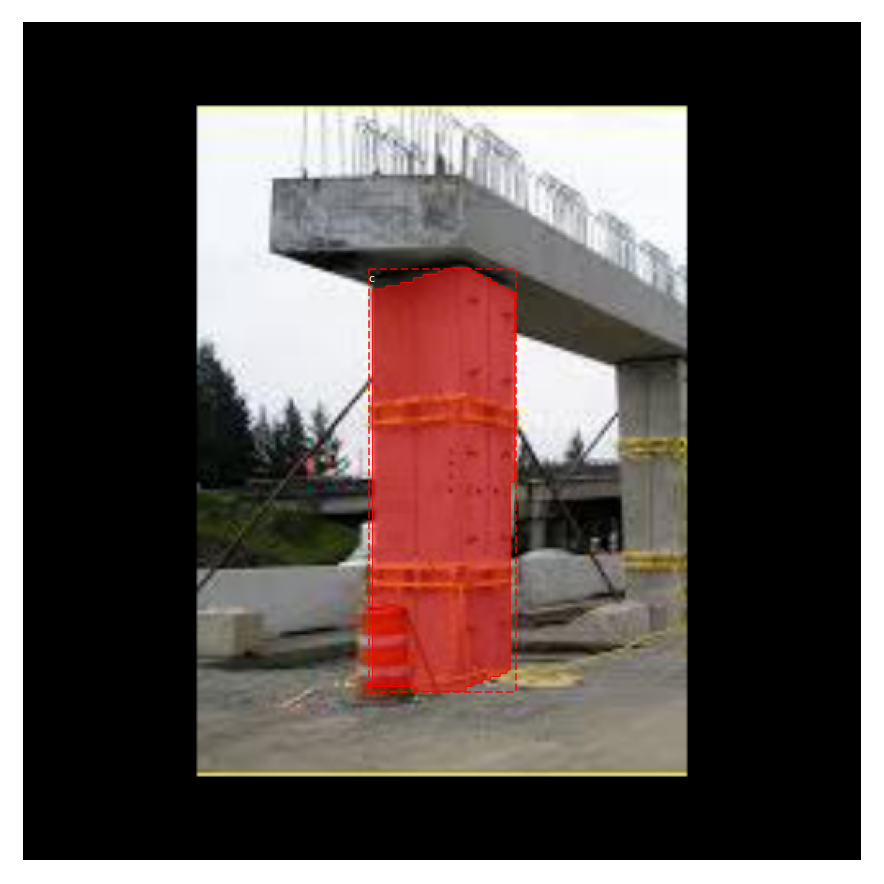

In [45]:
#visualization

from mrcnn import utils, visualize
bbox = utils.extract_bboxes(mask)
visualize.display_instances(image, bbox, mask, class_ids, "rectangular")